![DLI Logo](../assets/DLI_Header.png)

In [1]:
%%html
<video controls src="https://d36m44n9vdbmda.cloudfront.net/assets/s-ds-03-v1/videos/extraction.mp4" 
width=800>extraction</video>

# Introduction

In this module, you will learn how about model **extraction**. Extraction could be used to leak intellectual property or acquire a local copy of a model for further offline attack generation.

_model extraction_: Using queries to build a functionally equivalent model.

## Learning Objectives:

1. Learn about the class of extraction attacks. 
2. Extract an image model.

# Extraction
One of the more friendly attacks you can run is to "Extract" a model. You basically send a target model a load of data you found, train a local model, attack the local model, then try to "transfer" a locally created malicious sample to the online target model. This is a neat primitive that can be extremely effective and can be used in almost all operational settings. 

Extraction, unlike other gradient based attacks, only requires labeling a dataset. It does not even _necessarily_ require the dataset be relevant to the model, only to your use case. We covered more of the data analysis in the last lab, now we'll take a look at the formal setting. To extract a model we need a few things,

1. **The ability to submit inputs and observe outputs (we need feedback to learn from)**: Attacks in the wild are difficult if only because getting direct access to inputs and outputs is not a given. In this lab setting we have all the information we could possibly need to ensure success. We get clean `logits` on the output, we have access to weights, we know exactly what features the model requires. In this regard, the experiment we have set up is our "best case" scenario. However, in most cases you will interact with systems that require to upload an image of bytes, not a vector. Or did you notice that we've been working in batches of 10 (`torch.FloatTensor(10, 1, 28, 28)`)? Not all applications support batches, meaning you need to come up with your own batching scheme. 

2. **A representative dataset for the target model to label**: We've established that models will normally provide outputs even if the inputs aren't relevant. But when it comes to extracting a model, it's important to understand that you aren't extracting the exact model, you are simply modeling a model. Suppose you had access to a random 50% of the training data - how accurate would your copy-cat model be relative to the target model (trained on 100%)? Probably not as good without some careful modeling, and how would you know anyway? Or what do you think a copy-cat model would learn about other classes if you only had training data for a `7`? Find a dataset that will give you accurate insights for the task you want to perform. 

3. **A model architecture that is useful and relevant to creating the outputs we want**: You probably don't need the latest and greatest architecture, and you definitely don't need ChatGPT (though it can be used to collect a dataset - Alpaca style). Understand that algorithms are tools, each with its own purpose and reason for existing. Mathematics even has a theorem for this concept - there is "no free lunch". It's the idea that there is no one-size-fits-all algorithm or optimization strategy that works best for every problem. The "no free lunch" theorem states that any two optimization algorithms are equivalent when their performance is averaged across all possible problems. This means that there is no one algorithm that can outperform all others on every problem. Instead, the most effective algorithm for a particular problem depends on the specific characteristics of that problem. So like, experiment. A lot. 

Okay, let's extract model and attempt to transfer a locally created example to the online model.

# Imports and Model

In [1]:
# DO NOT CHANGE

import sys  # system-specific parameters and functions
import os, glob  # operating system and file system utilities
import numpy as np  # numerical computing library
import matplotlib.pyplot as plt  # plotting library
import torch  # machine learning framework
import torch.nn.functional as F  # torch neural network functional API
from torchvision import transforms  # image transformations for computer vision
from torch.utils.data import Dataset  # dataset class for loading data
from torch.utils.data import DataLoader  # data loader for batching data
from PIL import Image  # Python Imaging Library for image processing

# Set the device to use for computations (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)  # print the device being used

C:\Users\Usuario\Anaconda3\envs\llama\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


Here we stand up our trusty MobileNetV2 model. Now you've used it once, you can use it anywhere, the hard part is usually just setting it up the first time - which we have a suggested solution for in the next lab. In general, setting up models is something you should be comfortable doing (especially as some of you turn toward ML research). You'll get a feel for how or where errors are likely to come up, you'll learn about shapes, and how changing _just_ one tiny thing can cascade into a plethora of issues (before you put it back and just accept the fact that's how it's going to be for now). Not only that, but all the seemingly annoying pre and post processing steps represent an attack surface themselves.

Here we load everything all in a single cell because we already know what this does.  

In [2]:
# DO NOT CHANGE

#load the model from the pytorch hub
target_model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.DEFAULT', verbose=False)

# Put model in evaluation mode
target_model.eval()

# put the model on a GPU if available, otherwise CPU
target_model.to(device);

# Define the transforms for preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256
    transforms.CenterCrop(224),  # Crop the image to 224x224 about the center
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize the image with the ImageNet dataset mean values
        std=[0.229, 0.224, 0.225]  # Normalize the image with the ImageNet dataset standard deviation values
    )
]);

unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
   std= [1/s for s in [0.229, 0.224, 0.225]]
)

with open("data/labels.txt", 'r') as f:
    labels = [label.strip() for label in f.readlines()]

And what used to feel like a behemoth piece of code in the previous lab, now looks manageable. 

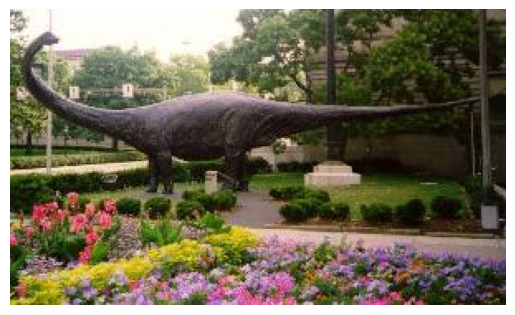

In [3]:
# DO NOT CHANGE

# load an example image
img = Image.open("data/101_ObjectCategories/brontosaurus/image_0001.jpg")

plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
# DO NOT CHANGE

# preprocess the image
img_tensor = preprocess(img).unsqueeze(0)

# move sample to the right device
img_tensor = img_tensor.to(device)

with torch.no_grad():
    output = target_model(img_tensor)

label_index = torch.argmax(output)
    
print(f"Pred Index:\n---------------\n{label_index}\n")
print(f"Pred Label:\n---------------\n{labels[label_index]}\n")

Pred Index:
---------------
51

Pred Label:
---------------
triceratops



That's a triceratops if we've ever seen one! But in all seriousness, a model will generally _always_ return an output so long as the input is valid. Our target model is trained on images that are `(3, 224, 224)`, but it does not require the pixels be bound of any particular value, only that it has the right shape. Yes, you read that correctly. Why would a model _not_ work on numbers outside the bounds of an RGB image, it's math. Further, a model can only return the labels that it knows about. The target model has no inherent knowledge of which labels map to which index. If you switched the position of the predicted label above with `horse` in labels, the above would return `horse`. Which is also another attack surface. 

# Extracting the Model
When executing this attack, it's usually best to find a dataset that is representative of your use case. There may be some internal structure the target model has learned about a particular dataset or domain. For example, if you were looking to extract a phishing model try and find a dataset of emails versus a dataset of novels. Since we already know what our target model is trained on, we simply went and found a dataset on the Internet that was seemingly representative. Which isn't very scientific, but we want to show how arbitrary data that "looks right" is the point - we'll explore a different strategy in the next lab.

:::{exercise}

1. Spend some time running different images against the target model.
2. Do any of the labels surprise you?

```python
test_img_path = "../data/101_ObjectCategories/brontosaurus/image_0001.jpg"
test_img = Image.open(test_img_path)
display(test_img)
test_img = preprocess(test_img).unsqueeze(0).to(device)
with torch.no_grad():
    label_index = torch.argmax(target_model(test_img))
print("Predicted Label: {}".format(labels[label_index]))
```
:::

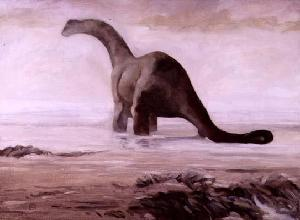

Predicted Label: Indian elephant


In [5]:
# your code here
test_img_path = "data/101_ObjectCategories/brontosaurus/image_0004.jpg"
test_img = Image.open(test_img_path)
display(test_img)
test_img = preprocess(test_img).unsqueeze(0).to(device)
with torch.no_grad():
    label_index = torch.argmax(target_model(test_img))
print("Predicted Label: {}".format(labels[label_index]))

:::{dropdown} Solution
You should notice many labels are wrong, and some patterns in labels can be obvious

:::{note}
Consider that with Generative techniques you can create almost [any dataset](https://arxiv.org/abs/2303.14126) you want...
:::

## Create and Label a Dataset
Next, we need to label the collected dataset. To do this we will send samples to the target model and collect outputs, then store them as a new dataset. We'll randomly sample images from the representative dataset, and we will cap target model queries with a `query_budget` constraint. This dataset will be what we use to train the copy-cat. We will create a custom torch `Dataset`, which is a fairly straight forward process. A torch `Dataset` is simply a Python class that inherits from `torch.utils.data import Dataset`, and implements `__init__`, `__len__`, and `__getitem__`. 

Creating these functions upfront will save you a lot of time in the backend when you want to turn this is into a pipeline. 

In [9]:
#help(glob)

In [6]:
# DO NOT CHANGE

# Define a custom dataset class for image extraction
class ExtractionDataset(Dataset):
    def __init__(self, target_model, data_dir, transform=None):
        # Initialize the dataset with the target model, data directory, and optional transform
        self.target_model = target_model  # the model used for extraction
        self.data_dir = data_dir  # the directory containing the image data
        self.transform = transform  # optional transform to apply to images
        self.image_filenames = glob.glob(data_dir + "**/*.jpg")  # list of image file paths
        self.label_cache = dict()  # cache for storing labels

    def __len__(self):
        # Return the number of imags in the dataset
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Getter for a single image and its corresponding label
        image_path = self.image_filenames[idx]  # get the image file path
        image = Image.open(image_path).convert('RGB')  # open the image and convert to RGB
        
        if self.transform:
            # Apply the transform to the image if provided
            img_tensor = self.transform(image).unsqueeze(0)  # transform and add batch dimension
            
            with torch.no_grad():
                # Run the image through the target model to get the output (label)
                output = self.target_model(img_tensor.to(device)).argmax(1)
        
        # squeeze it back for batching
        img_tensor = img_tensor.squeeze(0)
        
        return img_tensor, output  # return the image tensor and its corresponding label

# create the dataset
dataset = ExtractionDataset(target_model, "data/101_ObjectCategories/", preprocess)


Here we create the dataset. However, one important thing to note is that `__getitem__` **is not** executed until we request a sample using a `DataLoader`. This is neat for automatically labeling data using another models `predict` function. However, it might not be suitable in all settings. 

:::{warning} Opsec note
Consider how sending 5000 224x224 images might look in the logs.
:::

:::{exercise} Pop Quiz

1. How many samples are in the dataset?
2. What shape are they? 

:::

In [9]:
# your code here
print("number of samples", len(dataset))
print("sample image shape",dataset[0][0].shape)
print("sample output shape",dataset[0][1].shape)

number of samples 9144
sample image shape torch.Size([3, 224, 224])
sample output shape torch.Size([1])


:::{dropdown} Solution
```python
print("number of samples", len(dataset))
print("sample image shape",dataset[0][0].shape)
print("sample output shape",dataset[0][1].shape)
```

:::{note}
note that in `dataset[a][b]` `a` is the index indicating which sample to referene, and `b` would be either 0 or 1, where 0 is the datset's example input, and 1 is the dataset's example output

In [14]:
dataset[10][1]

tensor([401], device='cuda:0')

## Train a Model
In most real-world scenarios, simply getting labels for your data is the most challenging part. Most models are hiding behind APIs or other layers of complexity and abstraction. But once you get a dataset, you're now _firmly_ (you were when you were collecting the dataset, it just didn't fit with our narrative here) in the realm of being a Data Scientist. So, while you may have used some hacker magic to collect the dataset, that same magic won't necessarily help you make use of it. 

Next, we will train a copy-cat model to mimic the output of the target model. As we've done before in the earlier labs, we'll split our dataset into `train` and `eval` datasets, subject to a query budget.

In [7]:
# DO NOT CHANGE

query_budget = 5000

In [8]:
# DO NOT CHANGE

# get a bunch of images
permutation = torch.randperm(len(dataset))

# respect our query budget
train_idx = permutation[:query_budget]
eval_idx = permutation[query_budget:]

# create subsets
train_dataset = torch.utils.data.Subset(dataset, train_idx)
eval_dataset = torch.utils.data.Subset(dataset, eval_idx)

In [9]:
print(len(train_dataset))
len(eval_dataset)

5000


4144

We create indexes and then subset the dataset. There are some neat utilities in the `data` library, you should make a habit of looking in their libraries _before_ writing your own loops, etc.

Next we prepare a model to fine-tune, We pretend we don't know the target model and use a different pretrained `efficientnet` model. 

In [10]:
# DO NOT CHANGE
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True, verbose=False);

# explicitly set it to train mode vs eval
efficientnet.train()

# move it to the correct device
efficientnet.to(device);

C:\Users\Usuario/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\Usuario/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


You might be thinking -- how did we just _happen_ to choose a model with the same number of outputs? It makes it easier to pretend! Consider this is how a lot of the Adversarial ML research you read will work - it also saves us time for cooler stuff, not need to reimplement different processing functions. But more seriously, consider cases in which you only get the top 5 outputs from an unknown number of classes. You would need to carefully parse and store and labels and setup the copy-cat model architecture to reflect the number of labels you collected. Or come up with some other labeling strategy based on your goals. Which is _exactly_ what research is for!  

Next, we prepare the dataset using a `DataLoader`. This class basically iterates through the `dataset` and returns the data in batches or can even implement a sampling function.

In [11]:
# DO NOT CHANGE

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

And finally, because you're a pro, you'll recognize the below as our training loop.

In [12]:
# DO NOT CHANGE

# Initialize the optimizer for the efficientnet model
# using the Adamax algorithm with a learning rate of 1e-3
optimizer = torch.optim.Adamax(efficientnet.parameters(), lr=1e-3)

# Initialize the loss function for the model
# using the Cross-Entropy Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Initialize a list to store the epoch loss history
epoch_loss_hist = []

# Train the model for 5 epochs
for epoch in range(5):
    # Iterate over training data
    for x, y in train_dataloader:
        # Move input and label tensors to the device (GPU or CPU)
        x = x.to(device)
        y = y.to(device)
        
        # Zero the gradients of the model parameters so they are unaffected by the previous iteration
        optimizer.zero_grad()
        
        # Forward pass: get the output for input x
        yhat = efficientnet(x)
        
        # Calculate loss between the model's output and the true label
        loss = loss_fn(yhat, y.view(-1))
        
        # Backward pass: compute the gradients of the loss
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        # Store the current loss value in the loss history
        epoch_loss_hist.append(loss.detach().cpu().item())
        
        # Print the current epoch, step, and mean loss to the console
        sys.stdout.write("\r Epoch: {:3.0f}  Step: {:3.0f}  Mean loss: {:4.4f}".format(epoch, len(epoch_loss_hist), np.mean(epoch_loss_hist)))
        sys.stdout.flush()
    print()


 Epoch:   0  Step: 157  Mean loss: 1.9637
 Epoch:   1  Step: 314  Mean loss: 1.3619
 Epoch:   2  Step: 471  Mean loss: 1.0169
 Epoch:   3  Step: 628  Mean loss: 0.8049
 Epoch:   4  Step: 785  Mean loss: 0.6650


:::{exercise} Pop Quiz

While we wait for the copy-cat to train...

1. What do you think `x` and `y` are in the in the code following code copied from above? (it's not a 'gotcha')

```python
efficientnet.train();
for epoch in range(30):
    epoch_loss_hist = []
    for x,y in train_dataloader:
        ...
```

:::{dropdown} Solution
x is the training image, y is the label specified by the model being extracted. 

Next, we'll evaluate our model using a basic accuracy metric. Notice that we put the model in `eval` mode first!

In [13]:
# DO NOT CHANGE

from torch.utils.data import DataLoader

# create a DataLoader for your evaluation dataset
eval_dataloader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

# put model in evaluation mode
efficientnet.eval()

# initialize lists to store labels and predictions
true_labels = []
preds = []

for data, label in eval_dataloader:
    data = data.to(device)
    label = label.to(device)
    
    with torch.no_grad():
        output = efficientnet(data).argmax(1)

    # store labels and predictions on the GPU. Remember CPU->GPU->CPU is slooowww
    true_labels.append(label)
    preds.append(output)

# concatenate all tensors on the GPU
true_labels = torch.cat(true_labels)
preds = torch.cat(preds)

# accuracy
accuracy = (true_labels == preds).float().sum() / len(true_labels)

print(f"Accuracy:\n---------------\n{accuracy.item():.2f}\n")

Accuracy:
---------------
68.27



Accuracy is not amazing, but if we've done our job correctly the copy-cat model _should_ get similar output to the target model. While this is not a guarantee, in general there's _no_ reason with the right data and modeling this wouldn't work. It's math - that's how it works.

In [14]:
# DO NOT CHANGE

img_path = "data/101_ObjectCategories/dollar_bill/image_0013.jpg"
img = Image.open(img_path)

img_tensor = preprocess(img).unsqueeze(0)
img_tensor = img_tensor.to(device)

target_output = target_model(img_tensor)
target_score = torch.softmax(target_output, dim=1)[0][target_output[0].argmax()].item()

copycat_output = efficientnet(img_tensor)
cc_score = torch.softmax(copycat_output, dim=1)[0][copycat_output[0].argmax()].item()


print(f"Target output index:\n---------------\n{target_output[0].argmax().item()}\n")
print(f"Copycat output index:\n---------------\n{copycat_output[0].argmax().item()}\n")

print(f"Target output probs:\n---------------\n{target_score*100:.2f}%\n")
print(f"Copycat output probs:\n---------------\n{cc_score*100:.2f}%\n")

Target output index:
---------------
481

Copycat output index:
---------------
481

Target output probs:
---------------
3.72%

Copycat output probs:
---------------
99.68%



Hey, check that out. We got the same label but a vastly different probability score, that's to be expected. This means the models share at least _some_ of the same ideas about what our input is. While this residual accuracy could likely be attributed to being trained on the same task - it _does not_ mean the attack is only useful here. Consider that the primary method of training models is to take a base model and fine-tune it on your own dataset for your own task. This attack is the other side of that coin.  

:::{exercise}
Spend some time running different images against both models, can you find samples where the models disagree? Perhaps you could use the `dataset` from above to find disagreements.

```python
img_path = "../data/101_ObjectCategories/dollar_bill/image_0013.jpg"
img = Image.open(img_path)

...
```
:::

In [23]:
# your code here

img_path = "data/101_ObjectCategories/emu/image_0013.jpg"
img = Image.open(img_path)

img_tensor = preprocess(img).unsqueeze(0)
img_tensor = img_tensor.to(device)

target_output = target_model(img_tensor)
target_score = torch.softmax(target_output, dim=1)[0][target_output[0].argmax()].item()

copycat_output = efficientnet(img_tensor)
cc_score = torch.softmax(copycat_output, dim=1)[0][copycat_output[0].argmax()].item()


print(f"Target output index:\n---------------\n{target_output[0].argmax().item()}\n")
print(f"Copycat output index:\n---------------\n{copycat_output[0].argmax().item()}\n")

print(f"Target output probs:\n---------------\n{target_score*100:.2f}%\n")
print(f"Copycat output probs:\n---------------\n{cc_score*100:.2f}%\n")

Target output index:
---------------
355

Copycat output index:
---------------
355

Target output probs:
---------------
4.24%

Copycat output probs:
---------------
98.43%



:::{dropdown} Solution
You can try random images, or you can programmatically go through the dataset to find images that the newly trained model identifies incorrectly. These incorrectly identified images are labeled differently between the extracted model and the targeted model.

# Use the Copy-Cat
So far so good. We have a copy-cat of our target model and now we need to use it. Let's bring forward our `Carlini L2` attack from the evasion lab. Why not the others? Because we have gradients we can use! The important thing to remember here is that we're attacking an _offline_ copy of our target model.

In [15]:
# DO NOT CHANGE

def loss(output, mask, target_index, l2_weight):
    # Now we're removing the negative, we want it to be classified as the target_index
    classification_loss = torch.nn.functional.cross_entropy(output, target_index)
    
    # this says "No single pixel should be big, and the total magnitude of all of them should be small"
    l2_loss = torch.pow(mask, 2).sum()
    
    total_loss =  classification_loss+(l2_weight * l2_loss)
    
    # Now we penalize large distortions a bit less.
    return total_loss, classification_loss, l2_loss

Now we want to take our Brontosaurus and make it an Airplane to both the online and offline models.

In [17]:
# DO NOT CHANGE

# brontasauras..or bronta-sauras?
img = Image.open("data/101_ObjectCategories/brontosaurus/image_0001.jpg")
img_tensor = preprocess(img).unsqueeze(0)
img_tensor = img_tensor.to(device)

# airplane
tgt = Image.open("data/101_ObjectCategories/airplanes/image_0001.jpg")
tgt_tensor = preprocess(tgt).unsqueeze(0)
tgt_tensor = tgt_tensor.to(device)

In [18]:
# DO NOT CHANGE

# create the mask
mask = torch.randn_like(img_tensor)*1e-3
mask_parameter = torch.nn.Parameter(mask.to(device))

# create the optimizer
adv_optimizer = torch.optim.Adam([mask_parameter])

target_index = target_model(tgt_tensor)[0].argmax().unsqueeze(0).to(device)
copy_cat_index = efficientnet(tgt_tensor)[0].argmax().unsqueeze(0).to(device)

# print(copy_cat_index, target_index)

l2_weight = 0.5
step = 0

while True: # evaluate it until the prediction matches the target label
    output = efficientnet(img_tensor+mask_parameter)
    total_loss, class_loss, l2_loss = loss(output, mask_parameter, target_index, l2_weight)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    step+=1
    
    sys.stdout.write(f"\rStep: {step}  total loss: {total_loss.item():4.4f}    class loss:{class_loss.item():4.4f}     l2 loss: {l2_loss.item():4.4f}   Predicted class index:{output[0].argmax()}");
    sys.stdout.flush()
    
    if output[0].argmax().item() == target_index.item():
        break
        
print(f"\n\nWinner winner: {labels[output[0].argmax().item()]}")

Step: 2  total loss: 1.2036    class loss:1.1283     l2 loss: 0.1504   Predicted class index:895

Winner winner: warplane


And finally, let's see if it transfers to our target model...fingers crossed...

In [19]:
# DO NOT CHANGE

final_out = target_model(img_tensor + mask_parameter)

print(f"Offline class index:\n---------------\n{output[0].argmax().item()}\n")
print(f"Online class index:\n---------------\n{final_out[0].argmax().item()}\n")

Offline class index:
---------------
895

Online class index:
---------------
51



:::{exercise}
If your sample doesn't transfer right away, that's okay. This attack is so useful because it gives you options! There are a lot of places you can go from here - you could, 

1. Collect more data from the target model, or at least be more strategic... Here we showed you the mechanic, but we really weren't strategic about how we sampled the target model. 
2. Continue to train the copycat model. It didn't get a great accuracy score...
3. Change the architecture and try again...perhaps training a new model from scratch is better...
4. Or all of the above! 

The point is, you're sending benign traffic, modeling locally, and then getting periodic feedback on how well you're doing. 
:::

# Conclusion

Excellent. Another basic primitive in the bag. This is a favorite technique! We won't spend time blabbering on here, as this is basically just Data Science. We'll explore more of this in the next lab - albeit with a little bit of a twist. 

## What You Learned

1. Learn about the class of extraction attacks. 
2. Extract an image model.



**Head into the [next lab](2_extraction_the_hard_way.ipynb)**.

![DLI Logo](../assets/DLI_Header.png)